In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler



In [2]:
df = pd.read_csv('../../algoRev1/mockData/mockData.csv')
# df = pd.read_csv('../../data/cleanData/oneEncodedDiscord.csv')

df.head()

,Unnamed: 0,Bios,Year,Major_Dept,Ambition,Goals,Music,Sports,Friday_Nights,School_balance,Movie_Genres,Social_Style,Transfer
0,0,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,4,4,1,1,3,2,1,1,1,2,2
1,1,Hipster-friendly thinker. Food expert. Travel guru. Bacon practitioner. Introvert. Amateur zombie enthusiast.,2,6,2,2,2,7,2,1,11,1,1
2,2,Communicator. Unable to type with boxing gloves on. Typical web scholar. Tv lover.,2,7,3,2,1,6,1,2,4,2,1
3,3,Infuriatingly humble bacon enthusiast. Amateur beer maven. General tv practitioner. Web ninja.,3,6,3,2,5,2,2,2,10,3,1
4,4,Unapologetic internet lover. Baconaholic. Proud social media ninja. Food nerd. Award-winning twitter practitioner.,3,3,1,1,8,7,1,2,10,3,1


In [3]:
# df = df[['Bios']].join(
#               pd.DataFrame(
#           scaler.fit_transform(
#                                df.drop(columns='Bios',axis=1)), 
#                                index=df.index))

# df.head()

In [4]:

# Instantiating the Scaler
scaler = StandardScaler()
# scaler = MinMaxScaler()

for col in df.columns: 
    print(col) 

# Scaling the categories then replacing the old values
# df = df[['Bios']].join(
#               pd.DataFrame(
#           scaler.fit_transform(
#                                df.drop(columns='Bios',axis=1)), 
#                                index=df.index))

df = df[['Bios']] .join(
              pd.DataFrame(
          scaler.fit_transform(df.drop(columns=df[['Bios', 'Transfer']],axis=1))))

print('----------------------------------------------------------------------------') 
for col in df.columns: 
    print(col) 
# df = df[['Movie_Genres', 'Sports', 'Major_Dept', 'Year', 'Ambition', 'Goals', 'Music', 'Friday_Nights', 'School_balance', 'Social_Style', 'Transfer', 'Bios']] .join(
#               pd.DataFrame(
#           scaler.fit_transform(df.drop(columns=df[['Movie_Genres', 'Sports', 'Major_Dept', 'Year', 'Ambition', 'Goals', 'Music', 'Friday_Nights', 'School_balance', 'Social_Style', 'Transfer', 'Bios']],axis=1))))

# df[['Movie_Genres', 'Sports', 'Major_Dept', 'Year', 'Ambition', 'Goals', 'Music', 'Friday_Nights', 'School_balance', 'Social_Style', 'Transfer']] = scaler.fit_transform(df[['Movie_Genres', 'Sports', 'Major_Dept', 'Year', 'Ambition', 'Goals', 'Music', 'Friday_Nights', 'School_balance', 'Social_Style', 'Transfer']])




df.head()

Unnamed: 0
Bios
Year
Major_Dept
Ambition
Goals
Music
Sports
Friday_Nights
School_balance
Movie_Genres
Social_Style
Transfer
----------------------------------------------------------------------------
Bios
0
1
2
3
4
5
6
7
8
9
10


,Bios,0,1,2,3,4,5,6,7,8,9,10
0,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.000000,1.000000,0.428571,0.0,0.0,0.222222,0.111111,0.0,0.0,0.0,0.5
1,Hipster-friendly thinker. Food expert. Travel guru. Bacon practitioner. Introvert. Amateur zombie enthusiast.,0.001855,0.333333,0.714286,0.5,1.0,0.111111,0.666667,1.0,0.0,1.0,0.0
2,Communicator. Unable to type with boxing gloves on. Typical web scholar. Tv lover.,0.003711,0.333333,0.857143,1.0,1.0,0.000000,0.555556,0.0,0.5,0.3,0.5
3,Infuriatingly humble bacon enthusiast. Amateur beer maven. General tv practitioner. Web ninja.,0.005566,0.666667,0.714286,1.0,1.0,0.444444,0.111111,1.0,0.5,0.9,1.0
4,Unapologetic internet lover. Baconaholic. Proud social media ninja. Food nerd. Award-winning twitter practitioner.,0.007421,0.666667,0.285714,0.0,0.0,0.777778,0.666667,0.0,0.5,0.9,1.0


## --- Vectorization ---

This cell has the code for instantiating the Vectorizer, experimenting with both

Vectorization is transforming text to a vector. Takes every unique word and makes it its own column that tracks the count number


In [5]:
# Implementing CountVectorizer. 

vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['Bios'])

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)

new_df.drop('Bios', axis=1, inplace=True)
# new_df.drop('personal_qualities', axis=1, inplace=True)
# new_df.drop('friend_qualities', axis=1, inplace=True)

In [6]:
for col in new_df.columns: 
    print(col) 
new_df.head()


0
1
2
3
4
5
6
7
8
9
10
advocate
aficionado
alcohol
amateur
analyst
animals
avid
award
bacon
baconaholic
beer
boxing
buff
certified
charming
coffee
communicator
creator
culture
devoted
enthusiast
entrepreneur
evangelist
everywhere
evil
expert
explorer
extreme
fan
fanatic
food
foodaholic
freelance
friend
friendly
gamer
geek
general
gloves
guru
hardcore
hipster
humble
incurable
infuriatingly
internet
internetaholic
introvert
junkie
lifelong
lover
maven
media
music
musicaholic
nerd
ninja
of
on
organizer
passionate
pop
practitioner
problem
professional
proud
reader
scholar
social
solver
specialist
student
subtly
thinker
to
total
trailblazer
travel
troublemaker
tv
twitter
type
typical
unable
unapologetic
wannabe
web
winning
with
writer
zombie


,0,1,2,3,4,5,6,7,8,9,...,type,typical,unable,unapologetic,wannabe,web,winning,with,writer,zombie
0,0.000000,1.000000,0.428571,0.0,0.0,0.222222,0.111111,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
1,0.001855,0.333333,0.714286,0.5,1.0,0.111111,0.666667,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.003711,0.333333,0.857143,1.0,1.0,0.000000,0.555556,0.0,0.5,0.3,...,1,1,1,0,0,1,0,1,0,0
3,0.005566,0.666667,0.714286,1.0,1.0,0.444444,0.111111,1.0,0.5,0.9,...,0,0,0,0,0,1,0,0,0,0
4,0.007421,0.666667,0.285714,0.0,0.0,0.777778,0.666667,0.0,0.5,0.9,...,0,0,0,1,0,0,1,0,0,0


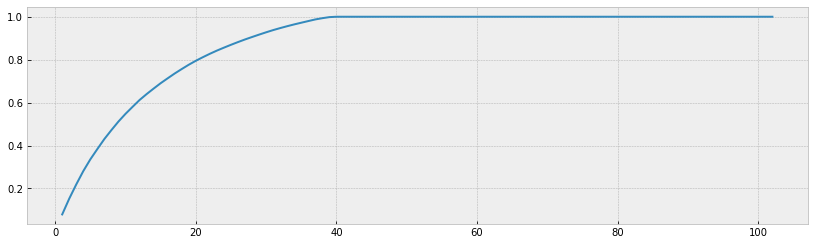

Number features: 32
Total Variance Explained: 0.9559938978449511
[[-0.9053902  -0.64297816 -0.60273877 ... -0.25572597 -0.08629344
   0.14127155]
 [-0.59189409 -1.76246999  1.096794   ...  0.20199558  0.29442986
  -0.30727253]
 [-0.61768832  1.27534551 -1.52577849 ...  0.028613   -0.11754583
   0.1025173 ]
 ...
 [-0.01792729  0.62172357  1.30099986 ...  0.14729406 -0.26144817
   0.11180359]
 [-0.07175655 -0.5420502  -0.10041418 ... -0.35265529  0.39876709
   0.46322229]
 [ 1.09567605  0.94285873  0.48130156 ... -0.65371593  0.51650365
  -0.00899789]]
0.9471501649483427


In [7]:
# Importing the library
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(new_df)
print(df_pca)
# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])


## -- Evaluation Metrics for Clustering --

Figuring out the optimal number of clusters using Silhouette Coef and the Davies-Bouldin Score. 

SC: higher the better, where 1 is the best and -1 is the worst. 

DB: lower the better

The cell below will generate a list of evaluation scores for all possible k values

In [8]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

## --- Plotting the scores ---

Max Value:
Cluster #     Cluster Score
19       0.443869

Min Value:
Cluster #    Cluster Score
2       0.089944


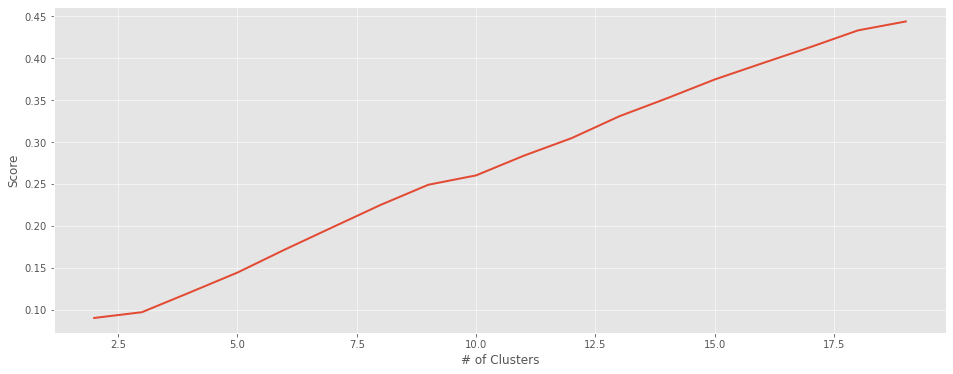

In [9]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)
# the higher the better (1 : best)


Max Value:
Cluster #    Cluster Score
2       3.365356

Min Value:
Cluster #     Cluster Score
19       1.120689


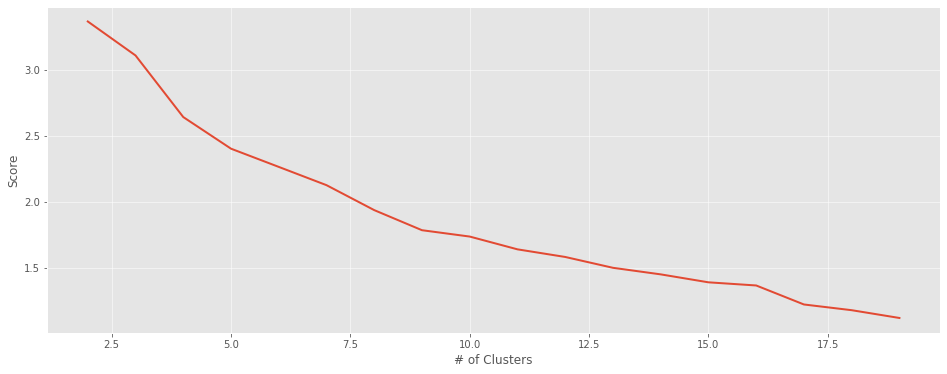

In [10]:
plot_evaluation(db_scores)
# the lower the better

## --- Running HAC ---

In [11]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=19)

# Fitting
hac.fit(df_pca)

scaler.fit(new_df)
# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
# df = df[['personal_qualities']].join(pd.DataFrame(scaler.inverse_transform(df.drop('personal_qualities', axis=1)), columns=df.columns[1:], index=df.index))

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,Bios,0,1,2,3,4,5,6,7,8,9,10,Cluster #
0,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.000000,1.000000,0.428571,0.0,0.0,0.222222,0.111111,0.0,0.0,0.0,0.5,0
1,Hipster-friendly thinker. Food expert. Travel guru. Bacon practitioner. Introvert. Amateur zombie enthusiast.,0.001855,0.333333,0.714286,0.5,1.0,0.111111,0.666667,1.0,0.0,1.0,0.0,14
2,Communicator. Unable to type with boxing gloves on. Typical web scholar. Tv lover.,0.003711,0.333333,0.857143,1.0,1.0,0.000000,0.555556,0.0,0.5,0.3,0.5,15
3,Infuriatingly humble bacon enthusiast. Amateur beer maven. General tv practitioner. Web ninja.,0.005566,0.666667,0.714286,1.0,1.0,0.444444,0.111111,1.0,0.5,0.9,1.0,17
4,Unapologetic internet lover. Baconaholic. Proud social media ninja. Food nerd. Award-winning twitter practitioner.,0.007421,0.666667,0.285714,0.0,0.0,0.777778,0.666667,0.0,0.5,0.9,1.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Explorer. Web scholar. Music lover. Infuriatingly humble beer fanatic.,0.992579,1.000000,0.428571,1.0,1.0,0.111111,0.333333,1.0,0.0,0.0,0.5,5
536,Pop culture ninja. Travel trailblazer. Food enthusiast. Unapologetic explorer.,0.994434,0.000000,0.428571,0.5,1.0,0.333333,0.666667,1.0,0.5,0.3,0.5,8
537,Typical zombie evangelist. Twitter guru. Tv geek. Avid pop culture buff. Explorer. Thinker. Proud troublemaker.,0.996289,0.666667,0.285714,1.0,1.0,1.000000,0.222222,1.0,0.5,0.6,0.5,3
538,Gamer. Friendly baconaholic. Tv junkie. Twitter enthusiast. Writer. Wannabe travel buff. Award-winning music advocate.,0.998145,1.000000,0.714286,1.0,1.0,0.888889,0.666667,1.0,0.0,1.0,0.0,1


## --- 5 clusters ---

In [12]:
rslt_df = df[df['Cluster #'] == 0]
rslt_df

# year mostly 4 (senior), mostly business  

,Bios,0,1,2,3,4,5,6,7,8,9,10,Cluster #
0,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.000000,1.000000,0.428571,0.0,0.0,0.222222,0.111111,0.0,0.0,0.0,0.5,0
11,Internet ninja. Total web practitioner. Lifelong twitter specialist. Writer. Friendly troublemaker.,0.020408,0.000000,0.857143,1.0,1.0,0.111111,0.444444,0.0,0.0,0.7,0.0,0
15,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.027829,1.000000,1.000000,0.0,1.0,0.444444,0.777778,1.0,1.0,0.5,1.0,0
26,Internet ninja. Total web practitioner. Lifelong twitter specialist. Writer. Friendly troublemaker.,0.048237,0.000000,0.857143,1.0,1.0,0.000000,0.888889,0.0,0.5,0.7,0.5,0
30,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.055659,0.000000,0.714286,0.0,0.0,0.222222,0.000000,0.0,1.0,0.8,0.5,0
41,Internet ninja. Total web practitioner. Lifelong twitter specialist. Writer. Friendly troublemaker.,0.076067,0.333333,0.142857,0.5,1.0,0.555556,0.333333,1.0,1.0,0.6,1.0,0
45,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.083488,0.333333,0.714286,0.0,1.0,1.000000,0.333333,0.0,1.0,0.2,1.0,0
56,Internet ninja. Total web practitioner. Lifelong twitter specialist. Writer. Friendly troublemaker.,0.103896,0.666667,1.000000,1.0,1.0,0.888889,1.000000,0.0,1.0,0.3,0.5,0
60,Friendly web ninja. Zombie practitioner. General travel lover. Reader.,0.111317,0.000000,0.142857,0.5,0.0,0.444444,0.333333,1.0,1.0,0.5,1.0,0
71,Internet ninja. Total web practitioner. Lifelong twitter specialist. Writer. Friendly troublemaker.,0.131725,0.000000,0.571429,0.0,0.0,0.444444,0.111111,0.0,0.0,0.7,0.0,0


In [13]:
rslt_df = df[df['Cluster #'] == 1]
rslt_df 


,Bios,0,1,2,3,4,5,6,7,8,9,10,Cluster #
349,Award-winning web nerd. Wannabe bacon junkie. Incurable reader. Analyst. Certified tv lover. Unapologetic creator.,0.647495,1.000000,0.714286,1.0,1.0,1.000000,0.000000,1.0,0.5,0.8,0.5,1
358,Gamer. Friendly baconaholic. Tv junkie. Twitter enthusiast. Writer. Wannabe travel buff. Award-winning music advocate.,0.664193,0.333333,0.714286,1.0,0.0,0.888889,0.888889,1.0,0.5,0.5,0.0,1
364,Award-winning web nerd. Wannabe bacon junkie. Incurable reader. Analyst. Certified tv lover. Unapologetic creator.,0.675325,0.333333,0.857143,1.0,0.0,0.777778,1.000000,1.0,1.0,0.2,1.0,1
373,Gamer. Friendly baconaholic. Tv junkie. Twitter enthusiast. Writer. Wannabe travel buff. Award-winning music advocate.,0.692022,0.666667,0.000000,0.5,0.0,0.777778,0.222222,0.0,0.5,0.7,1.0,1
379,Award-winning web nerd. Wannabe bacon junkie. Incurable reader. Analyst. Certified tv lover. Unapologetic creator.,0.703154,1.000000,1.000000,0.5,1.0,0.222222,0.555556,1.0,1.0,0.3,0.5,1
388,Gamer. Friendly baconaholic. Tv junkie. Twitter enthusiast. Writer. Wannabe travel buff. Award-winning music advocate.,0.719852,0.666667,0.857143,1.0,0.0,0.777778,0.111111,1.0,0.0,0.9,0.5,1
394,Award-winning web nerd. Wannabe bacon junkie. Incurable reader. Analyst. Certified tv lover. Unapologetic creator.,0.730983,1.000000,0.285714,0.5,1.0,0.444444,0.333333,0.0,1.0,0.3,0.0,1
403,Gamer. Friendly baconaholic. Tv junkie. Twitter enthusiast. Writer. Wannabe travel buff. Award-winning music advocate.,0.747681,0.000000,0.714286,1.0,1.0,0.888889,0.555556,0.0,0.0,0.3,0.5,1
409,Award-winning web nerd. Wannabe bacon junkie. Incurable reader. Analyst. Certified tv lover. Unapologetic creator.,0.758813,1.000000,0.571429,0.0,1.0,0.555556,0.111111,1.0,0.5,0.8,0.0,1
418,Gamer. Friendly baconaholic. Tv junkie. Twitter enthusiast. Writer. Wannabe travel buff. Award-winning music advocate.,0.775510,0.666667,0.000000,0.0,1.0,1.000000,0.888889,0.0,0.0,0.6,1.0,1


In [14]:
rslt_df = df[df['Cluster #'] == 2]
rslt_df 
# music usually > 5, humour = 3 mostly, entertainment, alot more kindness

,Bios,0,1,2,3,4,5,6,7,8,9,10,Cluster #
5,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.009276,0.333333,0.285714,1.0,0.0,0.777778,0.555556,0.0,0.0,0.5,0.0,2
20,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.037106,1.000000,0.000000,0.5,0.0,0.888889,0.888889,0.0,1.0,0.5,0.5,2
35,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.064935,0.000000,0.428571,1.0,1.0,0.222222,0.666667,1.0,0.0,0.5,0.0,2
50,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.092764,0.666667,0.000000,1.0,0.0,0.888889,0.333333,1.0,0.0,0.5,0.5,2
65,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.120594,0.666667,0.428571,0.0,0.0,1.000000,0.444444,1.0,0.5,0.2,1.0,2
80,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.148423,0.333333,0.857143,0.0,1.0,1.000000,0.777778,0.0,0.5,0.6,0.5,2
95,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.176252,0.000000,0.000000,0.0,0.0,1.000000,0.000000,1.0,1.0,0.5,1.0,2
110,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.204082,0.000000,0.857143,0.0,0.0,0.777778,0.222222,1.0,0.5,0.2,0.0,2
125,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.231911,0.000000,0.857143,1.0,1.0,0.444444,1.000000,0.0,0.0,0.5,0.5,2
140,Evil gamer. Music practitioner. Amateur social media lover. Food buff. Extreme zombie geek.,0.259740,0.000000,0.000000,0.0,1.0,0.666667,0.666667,0.0,0.0,0.6,1.0,2


In [15]:
rslt_df = df[df['Cluster #'] == 3]
rslt_df 

,Bios,0,1,2,3,4,5,6,7,8,9,10,Cluster #
354,Typical alcohol evangelist. Hardcore beer nerd. Pop culture aficionado. Infuriatingly humble tv buff. Coffee expert.,0.656772,0.000000,0.000000,0.5,0.0,0.666667,0.666667,0.0,0.0,0.5,0.5,3
357,Typical zombie evangelist. Twitter guru. Tv geek. Avid pop culture buff. Explorer. Thinker. Proud troublemaker.,0.662338,0.666667,0.428571,0.0,0.0,0.222222,0.555556,1.0,0.0,0.1,0.5,3
369,Typical alcohol evangelist. Hardcore beer nerd. Pop culture aficionado. Infuriatingly humble tv buff. Coffee expert.,0.684601,0.333333,1.000000,1.0,1.0,0.222222,0.111111,0.0,1.0,0.0,0.0,3
372,Typical zombie evangelist. Twitter guru. Tv geek. Avid pop culture buff. Explorer. Thinker. Proud troublemaker.,0.690167,0.000000,0.142857,1.0,1.0,1.000000,0.222222,1.0,0.0,0.2,0.0,3
384,Typical alcohol evangelist. Hardcore beer nerd. Pop culture aficionado. Infuriatingly humble tv buff. Coffee expert.,0.712430,1.000000,0.000000,1.0,1.0,0.222222,0.222222,0.0,0.5,1.0,0.0,3
387,Typical zombie evangelist. Twitter guru. Tv geek. Avid pop culture buff. Explorer. Thinker. Proud troublemaker.,0.717996,1.000000,0.142857,0.5,1.0,1.000000,0.333333,1.0,1.0,0.7,0.0,3
399,Typical alcohol evangelist. Hardcore beer nerd. Pop culture aficionado. Infuriatingly humble tv buff. Coffee expert.,0.740260,0.000000,0.428571,0.5,0.0,0.333333,0.333333,1.0,0.0,0.8,1.0,3
402,Typical zombie evangelist. Twitter guru. Tv geek. Avid pop culture buff. Explorer. Thinker. Proud troublemaker.,0.745826,1.000000,0.428571,0.0,0.0,0.888889,0.777778,0.0,1.0,0.3,1.0,3
414,Typical alcohol evangelist. Hardcore beer nerd. Pop culture aficionado. Infuriatingly humble tv buff. Coffee expert.,0.768089,0.666667,0.571429,1.0,0.0,0.777778,0.222222,1.0,0.5,1.0,0.0,3
417,Typical zombie evangelist. Twitter guru. Tv geek. Avid pop culture buff. Explorer. Thinker. Proud troublemaker.,0.773655,0.666667,0.857143,1.0,0.0,0.444444,0.444444,0.0,0.0,0.8,0.0,3


In [16]:
rslt_df = df[df['Cluster #'] == 4]
rslt_df 

# very close match of the qualities and entertainment

,Bios,0,1,2,3,4,5,6,7,8,9,10,Cluster #
12,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.022263,1.000000,0.714286,1.0,0.0,0.666667,0.888889,0.0,0.5,0.0,0.0,4
27,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.050093,0.666667,0.571429,0.5,1.0,0.777778,0.777778,0.0,0.5,0.9,0.0,4
42,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.077922,0.000000,0.571429,1.0,0.0,1.000000,0.666667,1.0,0.5,0.7,0.0,4
57,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.105751,0.666667,0.142857,0.5,1.0,0.444444,0.111111,0.0,1.0,0.6,0.0,4
72,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.133581,0.333333,0.571429,0.5,0.0,1.000000,0.555556,1.0,0.5,0.0,0.5,4
87,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.161410,0.000000,0.285714,0.5,1.0,0.888889,0.666667,0.0,1.0,0.3,0.0,4
102,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.189239,1.000000,0.142857,1.0,0.0,0.666667,0.333333,1.0,0.5,0.1,1.0,4
117,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.217069,0.666667,0.285714,1.0,1.0,0.111111,0.222222,1.0,1.0,0.0,0.0,4
132,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.244898,1.000000,0.857143,1.0,0.0,0.333333,0.333333,1.0,1.0,0.5,0.5,4
147,Creator. Subtly charming introvert. Entrepreneur. Professional tv ninja.,0.272727,1.000000,0.857143,0.0,1.0,0.555556,0.000000,0.0,0.0,0.3,0.0,4


## --- 3 clusters ---

In [17]:
# Not the best because I personally din't see much difference in clusters

In [18]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(rslt_df[['Music', 'Year']], method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

KeyError: "None of [Index(['Music', 'Year'], dtype='object')] are in the [columns]"

In [554]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')

y_hc=hc.fit_predict(rslt_df[['Music', 'Year']])

In [555]:
plt.scatter(rslt_df[y_hc==0, 0], rslt_df[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(rslt_df[y_hc==1, 0], rslt_df[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(rslt_df[y_hc==2, 0], rslt_df[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(rslt_df[y_hc==3, 0], rslt_df[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(rslt_df[y_hc==4, 0], rslt_df[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Customers (Hierarchical Clustering Model)')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.show()

TypeError: '(array([False, False,  True,  True,  True, False, False, False,  True,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False]), 0)' is an invalid key